# Transferability of Evasion Attacks

Transferability captures the ability of an attack against a machine-learning 
 model to be effective against a different, potentially unknown, model.
 
In this tutorial we are going to test if an evasion attack generated against
 a Support Vector Machine (SVM), the *surrogate* classifier, will transfer 
 to other classifiers, the *targets*, or not.

For more details about the transferability property of adversarial attacks 
 please refer to:
  
  > [[demontis19-usenix]](https://www.usenix.org/conference/usenixsecurity19/presentation/demontis) 
  > Demontis, A., Melis, M., Pintor, M., Jagielski, M., Biggio, B., Oprea, A., 
  > Nita-Rotaru, C. and Roli, F., 2019. Why Do Adversarial Attacks Transfer? 
  > Explaining Transferability of Evasion and Poisoning Attacks. In 28th Usenix 
  > Security Symposium, Santa Clara, California, USA.
 
We will first create and train the surrogate and different target classifiers, 
 evaluating their performance in the standard scenario, *i.e. not under attack*.
 The surrogate and the target classifiers will be trained on different training sets.
 
The following part partially replicates the procedure from the [first tutorial](01-Training.ipynb).

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](
https://colab.research.google.com/github/pralab/secml/blob/HEAD/tutorials/04-Transferability.ipynb)

In [1]:
%%capture --no-stderr --no-display
# NBVAL_IGNORE_OUTPUT

try:
  import secml
except ImportError:
  %pip install git+https://gitlab.com/secml/secml

In [2]:
random_state = 999

n_features = 2  # Number of features
n_samples = 2250  # Number of samples
centers = [[-2, 0], [2, -2], [2, 2]]  # Centers of the clusters
cluster_std = 0.8  # Standard deviation of the clusters

from secml.data.loader import CDLRandomBlobs
dataset = CDLRandomBlobs(n_features=n_features, 
                         centers=centers, 
                         cluster_std=cluster_std,
                         n_samples=n_samples,
                         random_state=random_state).load()

n_tr = 1000  # Number of training set samples
n_ts = 250  # Number of test set samples

# Split in training and test.
from secml.data.splitter import CTrainTestSplit
splitter = CTrainTestSplit(
    train_size=2 * n_tr, test_size=n_ts, random_state=random_state)
tr, ts = splitter.split(dataset)

# Normalize the data
from secml.ml.features import CNormalizerMinMax
nmz = CNormalizerMinMax()
tr.X = nmz.fit_transform(tr.X)
ts.X = nmz.transform(ts.X)

# Generate 2 training datasets for surrogate and target classifiers
tr1 = tr[:n_tr, :]  # Source classifier training set
tr2 = tr[n_tr:, :]  # Target classifier training set

from collections import namedtuple
CLF = namedtuple('CLF', 'clf_name clf xval_parameters')

from secml.ml.classifiers.multiclass import CClassifierMulticlassOVA
# Binary classifiers
from secml.ml.classifiers import CClassifierSVM, CClassifierSGD
# Natively-multiclass classifiers
from secml.ml.classifiers import CClassifierKNN, CClassifierDecisionTree, CClassifierRandomForest

# Let's create a 3-Fold data splitter
from secml.data.splitter import CDataSplitterKFold
xval_splitter = CDataSplitterKFold(num_folds=3, random_state=random_state)

# Metric to use for training and performance evaluation
from secml.ml.peval.metrics import CMetricAccuracy
metric = CMetricAccuracy()

surr_clf = CLF(
    clf_name='SVM Linear',
    clf=CClassifierMulticlassOVA(CClassifierSVM, kernel='linear'),
    xval_parameters={'C': [1e-2, 0.1, 1]})

print("Estimating the best training parameters of the surrogate classifier...")
best_params = surr_clf.clf.estimate_parameters(
    dataset=tr1, 
    parameters=surr_clf.xval_parameters, 
    splitter=xval_splitter, 
    metric=metric, 
    perf_evaluator='xval'
)

print("The best training parameters of the surrogate classifier are: ", 
      [(k, best_params[k]) for k in sorted(best_params)])

surr_clf.clf.fit(tr1.X, tr1.Y)

y_pred = surr_clf.clf.predict(ts.X)

acc = metric.performance_score(y_true=ts.Y, y_pred=y_pred)

print("Accuracy of the surrogate classifier on test set: {:.2%}".format(acc))

print("\nTraining the target classifiers...")

target_clf_list = [
    CLF(
        clf_name='SVM Linear',
        clf=CClassifierMulticlassOVA(CClassifierSVM, kernel='linear'),
        xval_parameters={'C': [1e-2, 0.1, 1]}),
    CLF(clf_name='SVM RBF',
        clf=CClassifierMulticlassOVA(CClassifierSVM, kernel='rbf'),
        xval_parameters={'C': [1e-2, 0.1, 1],  'kernel.gamma': [1, 10, 100]}),
    CLF(clf_name='Logistic (SGD)',
        clf=CClassifierMulticlassOVA(
            CClassifierSGD, regularizer='l2', loss='log', 
            random_state=random_state),
        xval_parameters={'alpha': [1e-6, 1e-5, 1e-4]}),
    CLF(clf_name='kNN',
        clf=CClassifierKNN(),
        xval_parameters={'n_neighbors': [30, 40, 50]}),
    CLF(clf_name='Decision Tree',
        clf=CClassifierDecisionTree(random_state=random_state),
        xval_parameters={'max_depth': [1, 3, 5]}),
    CLF(clf_name='Random Forest',
        clf=CClassifierRandomForest(random_state=random_state),
        xval_parameters={'n_estimators': [20, 30, 40]}),
]

for i, test_case in enumerate(target_clf_list):
    
    clf = test_case.clf
    xval_params = test_case.xval_parameters
    
    print("\nEstimating the best training parameters of {:} ..."
          "".format(test_case.clf_name))
    
    best_params = clf.estimate_parameters(
        dataset=tr2, parameters=xval_params, splitter=xval_splitter, 
        metric='accuracy', perf_evaluator='xval')
    
    print("The best parameters for '{:}' are: ".format(test_case.clf_name), 
          [(k, best_params[k]) for k in sorted(best_params)])
    
    print("Training of {:} ...".format(test_case.clf_name))
    clf.fit(tr2.X, tr2.Y)
    
    # Predictions on test set and performance evaluation
    y_pred = clf.predict(ts.X)
    acc = metric.performance_score(y_true=ts.Y, y_pred=y_pred)

    print("Classifier: {:}\tAccuracy: {:.2%}".format(test_case.clf_name, acc))

Estimating the best training parameters of the surrogate classifier...
The best training parameters of the surrogate classifier are:  [('C', 0.1)]
Accuracy of the surrogate classifier on test set: 99.60%

Training the target classifiers...

Estimating the best training parameters of SVM Linear ...
The best parameters for 'SVM Linear' are:  [('C', 0.1)]
Training of SVM Linear ...
Classifier: SVM Linear	Accuracy: 99.60%

Estimating the best training parameters of SVM RBF ...
The best parameters for 'SVM RBF' are:  [('C', 0.01), ('kernel.gamma', 10)]
Training of SVM RBF ...
Classifier: SVM RBF	Accuracy: 99.60%

Estimating the best training parameters of Logistic (SGD) ...
The best parameters for 'Logistic (SGD)' are:  [('alpha', 1e-06)]
Training of Logistic (SGD) ...
Classifier: Logistic (SGD)	Accuracy: 99.60%

Estimating the best training parameters of kNN ...
The best parameters for 'kNN' are:  [('n_neighbors', 30)]
Training of kNN ...
Classifier: kNN	Accuracy: 99.60%

Estimating the be

## Generation of the Adversarial Examples

As done in the [evasion tutorial](03-Evasion.ipynb), we now craft the adversarial
 examples using the **gradient-based maximum-confidence** algorithm for generating 
 evasion attacks, implemented by the `CAttackEvasionPGDLS` class (`e-pgd-ls`).

This time, we are going to generate an **error-specific** attack by setting 
 `y_target` to one of the classes of the dataset. In this way, we enforce 
 the solver to perturb the points so that the classifier will classify them 
 with the `y_true` label.
  
*Please note that the attack on multiple samples may take a while 
 (up to a few minutes) depending on the machine the script is run on.*

In [3]:
noise_type = 'l2'  # Type of perturbation 'l1' or 'l2'
dmax = 0.4  # Maximum perturbation
lb, ub = 0, 1  # Bounds of the attack space. Can be set to `None` for unbounded
y_target = 2  # `error-specific` attack. None for `error-generic`

# Should be chosen depending on the optimization problem
solver_params = {
    'eta': 1e-1, 
    'eta_min': 0.1, 
    'eta_max': None, 
    'max_iter': 100, 
    'eps': 1e-4
}

from secml.adv.attacks.evasion import CAttackEvasionPGDLS
pgd_ls_attack = CAttackEvasionPGDLS(
    classifier=surr_clf.clf,
    double_init_ds=tr1,
    double_init=False,
    distance=noise_type, 
    dmax=dmax, 
    lb=lb, ub=ub,
    solver_params=solver_params,
    y_target=y_target)

# Run the evasion attack on x0
print("Attack started...")
y_pred, scores, adv_ds, f_obj = pgd_ls_attack.run(ts.X, ts.Y)
print("Attack complete!")

Attack started...
Attack complete!


## Analysis of Transferability

Let's now test if the previously generated examples transfer to other models.

Initally, we test the performance of each target classifier on the adversarial
 examples. Later, we plot few of the samples on a 2D plane.


Testing transferability of SVM Linear
Test error (no attack): 0.40%

Testing transferability of SVM RBF
Test error (no attack): 0.40%

Testing transferability of Logistic (SGD)
Test error (no attack): 0.40%

Testing transferability of kNN
Test error (no attack): 0.40%

Testing transferability of Decision Tree
Test error (no attack): 1.20%

Testing transferability of Random Forest
Test error (no attack): 1.20%


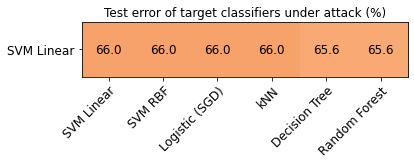


Average transfer rate: 65.87%


In [4]:
# Metric to use for testing transferability
from secml.ml.peval.metrics import CMetricTestError
metric = CMetricTestError()

trans_error = []
transfer_rate = 0.0
for target_clf in target_clf_list:
    
    print("\nTesting transferability of {:}".format(target_clf.clf_name))
    
    origin_error = metric.performance_score(
            y_true=ts.Y, y_pred=target_clf.clf.predict(ts.X))
    
    print("Test error (no attack): {:.2%}".format(origin_error))
    
    trans_error_clf = metric.performance_score(
        y_true=ts.Y, y_pred=target_clf.clf.predict(adv_ds.X))
        
    trans_error.append(trans_error_clf)
    transfer_rate += trans_error_clf
    
# Computing the transfer rate
transfer_rate /= len(target_clf_list)

from secml.array import CArray
trans_acc = CArray(trans_error) * 100  # Show results in percentage

from secml.figure import CFigure
# Only required for visualization in notebooks
%matplotlib inline

fig = CFigure(height=1)
a = fig.sp.imshow(trans_acc.reshape((1, 6)), 
                  cmap='Oranges', interpolation='nearest',
                  alpha=.65, vmin=60, vmax=70)

fig.sp.xticks(CArray.arange((len(target_clf_list))))
fig.sp.xticklabels([c.clf_name for c in target_clf_list], 
                   rotation=45, ha="right", rotation_mode="anchor")
fig.sp.yticks([0])
fig.sp.yticklabels([surr_clf.clf_name])

for i in range(len(target_clf_list)):
    fig.sp.text(i, 0, trans_acc[i].round(2).item(), va='center', ha='center')
    
fig.sp.title("Test error of target classifiers under attack (%)")
    
fig.show()

print("\nAverage transfer rate: {:.2%}".format(transfer_rate))

We can observe how the accuracy of the target classifiers on the adversarial 
 point generated against the surrogate classifier is extremely low, which 
 highlights how the machine-learning models are **vulnerable to transfer attacks**.

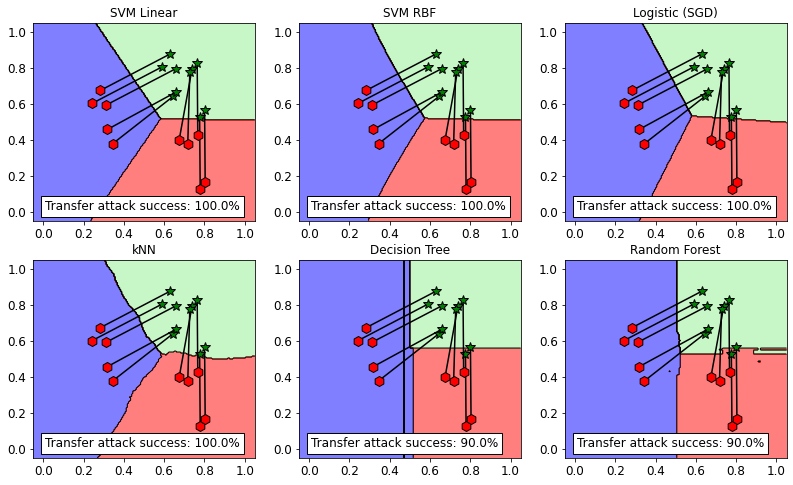

In [5]:
from secml.figure import CFigure
from secml.array import CArray
from math import ceil
fig = CFigure(width=4.5 * len(target_clf_list) / 2, 
              height=4 * 2, markersize=10)

for clf_idx in range(len(target_clf_list)):
    clf = target_clf_list[clf_idx].clf

    fig.subplot(2, int(ceil(len(target_clf_list) / 2)), clf_idx + 1)
    fig.sp.title(target_clf_list[clf_idx].clf_name)
    
    fig.sp.plot_decision_regions(clf, n_grid_points=200)
    fig.sp.grid(grid_on=False)
    
    s_idx = ts.Y.find(ts.Y != y_target)
    
    for pt in s_idx[:10]:  # Plot the translation of multiple adversarial samples
        pt_segment = CArray.append(ts.X[pt, :], adv_ds.X[pt, :], axis=0)
        fig.sp.plot_path(pt_segment)
        
    acc = metric.performance_score(
        y_true=ts[s_idx[:10], :].Y, y_pred=clf.predict(adv_ds[s_idx[:10], :].X))
        
    fig.sp.text(0.01, 0.01, "Transfer attack success: {:.1%}".format(acc), 
                bbox=dict(facecolor='white'))

fig.show()


These 2D plot clearly visualize the vulnerability of the target classifiers.
 The adversarial examples (green stars) which are inside the `y_target = 2` 
 green decision region, are successfully transfered.